# OCR cyrillic

**Структура проекта:**  

| Файл | Описание |
| --- | --- |
| **[castom_utils.py](castom_utils.py)** | Кастомные функции, используемые в нескольких ноутбуках. |
| **[config.yaml](config.yaml)** | Конфигурационный файл. Можно отредактировать вручную или из данного ноутбука. |
| **[pdf_to_images.ipynb](pdf_to_images.ipynb)** | Скрипт для конвертации PDF файлов с текстовым слоем в отдельные изображения и текст. Можно применять для создания тестового датасета. |
| **[synthetic_datasets.ipynb](synthetic_datasets.ipynb)** | В данном ноутбуке реализован парсинг и предобработка текста а так же создание на его основе синтетических датасетов из изображений для обучения моделей распознавания и детекции. |
| **[train_recognition.ipynb](train_recognition.ipynb)** | Обучение модели распознавания текста. |
| **[train_detection.ipynb](train_detection.ipynb)** | Обучение модели детекции текста. |
| **[ocr_cyrillic.ipynb](ocr_cyrillic.ipynb)** | Объединение ранее обученных моделей в одну OCR модель и тестирование на реальных данных. Сравнение результатов с готовыми решениями для работы с русскоязычным текстом. |


**Цель проекта:** обучить OCR модель для задачи распознавания текстов русскоязычных книг. Произвести сравнение полученной модели с готовыми решениями, которые "из коробки" работают с русским языком.

**Метрики:**
- **[CER](https://torchmetrics.readthedocs.io/en/v0.8.2/text/char_error_rate.html) (Char Error Rate)** $= \frac{S + D + I}{N} = \frac{S + D + I}{S + D + C}$, где
    - **S** is the number of substitutions,
    - **D** is the number of deletions,
    - **I** is the number of insertions,
    - **C** is the number of correct characters,
    - **N** is the number of characters in the reference ($N=S+D+C$).
<br><br>
- **[WER](https://torchmetrics.readthedocs.io/en/v0.8.2/text/word_error_rate.html) (Word Error Rate)** - рассчитывается аналогично **CER**, но на уровне отдельных слов, а не символов.

**Основные разделы:**
- [Datasets](#Datasets) - описание датасетов, на которых будут тестироваться модели.
- [DocTR](#DocTR) - подготовка и тестирование обученной нами модели.
- **Тесты готовых решений**:
    - [EasyOCR](#EasyOCR)
    - [Tesseract](#Tesseract)
    - [PaddleOCR](#PaddleOCR)
- [Summary](#Summary)

## Imports

In [1]:
# !pip install "python-doctr[torch,viz,html,contrib]"

In [2]:
import gc
import re
import json
import yaml
import shutil
import random
from itertools import chain
from tqdm.auto import tqdm
from typing import List, Optional
from termcolor import colored  # https://github.com/termcolor/termcolor

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import cv2
from skimage.filters import threshold_sauvola

import torch
from doctr.models import ocr_predictor, recognition, detection
from doctr import transforms as T
from torchvision.transforms import v2
import albumentations as A

from torchmetrics.text import CharErrorRate, WordErrorRate
from torchmetrics.functional.text import char_error_rate, word_error_rate
import Levenshtein

from castom_utils import load_config, Ansi, read_json, translate_text, ColorShiftAlb

In [3]:
def get_central_crop(img, crop_size):
    img = np.array(img)
    h, w = img.shape[:2]

    start_x = (w - crop_size[0]) // 2
    start_y = (h - crop_size[1]) // 2
    cropped = img[start_y:start_y + crop_size[1], start_x:start_x + crop_size[0], :]
    return cropped


def show_dataset(dataset_path, title: str, crop_size=(400, 300), num=3):
    images = list(dataset_path.rglob('*.png'))
    random_images = random.choices(images, k=num)
    
    fig, ax = plt.subplots(2, num, figsize=(17, 12),  
                           gridspec_kw={
                               'height_ratios': (1, .52),
                               'wspace': .01,
                               'hspace': .15,
                           })
    fig.suptitle(title, fontweight='bold')

    for i in range(num):
        img = Image.open(random_images[i])
        img_crop = get_central_crop(img, crop_size)
        
        ax[0, i].set_title(f'size: {img.size}')
        ax[0, i].imshow(img)
        # ax[0, i].set_box_aspect(1.5)
        ax[0, i].axis('off')

        ax[1, i].set_title(f'crop: {crop_size}')
        ax[1, i].imshow(img_crop)
        # ax[0, i].set_box_aspect(1.33)
        ax[1, i].axis('off')

    plt.show()

In [4]:
def edit_dataset(source_dataset, new_dataset, preprocess, *args):
    """
    Функция для преобразования изображений в датасете.
    В preprocess передать функцию для преобразования.
    """
    new_dataset.joinpath('images').mkdir(parents=True, exist_ok=True)
    shutil.copy(source_dataset / 'labels.json', new_dataset)
    
    annotations = read_json(new_dataset / 'labels.json')
    for img_name in tqdm(list(annotations.keys())):
        img = Image.open(source_dataset / 'images' / img_name)

        # Обработка переданной функцией
        img = preprocess(img, *args)

        img.save(new_dataset / 'images' / img_name)

In [5]:
def highlight_diff(gt, pred):
    """
    Выделение ошибок в предсказанном тексте
    """
    opcodes = Levenshtein.opcodes(gt, pred)
    result = []
    for tag, i1, i2, j1, j2 in opcodes:
        part_txt = pred[j1:j2]
        
        match tag:
            case 'equal':
                result.append(part_txt)
            case 'replace' | 'insert':
                if part_txt == ' ':
                    result.append(colored('[SPACE]', 'red'))
                else:
                    result.append(colored(part_txt, 'red'))
            case 'delete':
                result.append(colored('[DEL]', 'red', attrs=['bold']))
                
    return ''.join(result)

In [6]:
def get_predict_doctr(model, img_array, return_boxes=False):
    # Получаем размеры изображения
    height, width = img_array.shape[:2]

    # Прогноз модели
    output = model([img_array])
    pred_text = output.render() + '\n'

    if not return_boxes:
        return pred_text

    # Получаем координаты боксов
    boxes = []
    pages = output.pages
    for page in pages:
        for block in page.blocks:
            for line in block.lines:
                for word in line.words:
                    # tuple(tuple, tuple) -->  list
                    bbox = list(chain(*word.geometry))
                    # Денормируем координаты
                    bbox = [int(i * j) for i, j in zip(bbox, [width, height, width, height])]
                    boxes.append(bbox)

    return pred_text, boxes, 'rectangle'

In [7]:
def calculation_score(model, predict_func, path_dataset, translate_gt=False):
    """
    Оценка точности модели на тестовом датасете.
    """
    gc.collect()
    torch.cuda.empty_cache()

    metric_cer = CharErrorRate()
    metric_wer = WordErrorRate()

    annotations = read_json(path_dataset / 'labels.json')
    
    lengths = {
        'gt': {'char': [], 'word': []},
        'pred': {'char': [], 'word': []}
    }
    
    for img_name, labels in tqdm(list(annotations.items())):
        gt_text = labels['text']
        if translate_gt:
            gt_text = translate_text(gt_text, CFG.vocab_replace)
        
        img_path = path_dataset.joinpath('images', img_name)
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)

        pred_text = predict_func(model, img_array, return_boxes=False)
        
        metric_cer.update(pred_text, gt_text)
        metric_wer.update(pred_text, gt_text)

        # Записываем длину текста в символах и отдельных словах
        lengths['gt']['char'].append(len(gt_text))
        lengths['gt']['word'].append(len(gt_text.split()))
        lengths['pred']['char'].append(len(pred_text))
        lengths['pred']['word'].append(len(pred_text.split()))

    cer = metric_cer.compute().item()
    wer = metric_wer.compute().item()

    print(
        f"Lengths GT:   (chars: {np.mean(lengths['gt']['char']):.0f}, words: {np.mean(lengths['gt']['word']):.0f})\n"
        f"Lengths pred: (chars: {np.mean(lengths['pred']['char']):.0f}, words: {np.mean(lengths['pred']['word']):.0f})\n\n"
        f"CER:     {Ansi.bold}{cer:.4f}{Ansi.end}\n"
        f"WER:     {Ansi.bold}{wer:.4f}{Ansi.end}"
    )

In [8]:
def show_predict(model, predict_func, path_dataset, img_name, img_size=8, title: str | None = None, translate_gt=False):
    """
    Отрисовка bboxes и получение предсказания для одного изображения
    """
    gc.collect()
    torch.cuda.empty_cache()

    annotations = read_json(path_dataset / 'labels.json')
    gt_text = annotations[img_name]['text']

    if translate_gt:
        gt_text = translate_text(gt_text, CFG.vocab_replace)

    img_path = path_dataset.joinpath('images', img_name)
    img = Image.open(img_path).convert('RGB')
    img_array = np.array(img)
    draw = ImageDraw.Draw(img)

    # Получаем предсказания модели
    pred_text, boxes, boxmode = predict_func(model, img_array, return_boxes=True)

    if boxes is not None:
        for bbox in boxes:
            getattr(draw, boxmode)(bbox, outline='green', width=2)

    plt.figure(figsize=(img_size, img_size))
    plt.title(title)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Выделение ошибок предсказания
    pred_text_highlight = highlight_diff(gt_text, pred_text)

    # Расчет метрик
    cer = char_error_rate(pred_text, gt_text)
    wer = word_error_rate(pred_text, gt_text)
    
    print(
        f'CER: {Ansi.bold}{cer:.4f}{Ansi.end}\n'
        f'WER: {Ansi.bold}{wer:.4f}{Ansi.end}\n\n'
        f'{"-" * 80}\n'
        f'{Ansi.bold}{Ansi.underline}Ground Truth{Ansi.end} {Ansi.bold}(chars:{len(gt_text)}, words:{len(gt_text.split())}){Ansi.end}\n'
        f'{gt_text}\n'
        f'{"-" * 80}\n'
        f'{Ansi.bold}{Ansi.underline}Prediction{Ansi.end} {Ansi.bold}(chars:{len(pred_text)}, words:{len(pred_text.split())}){Ansi.end}\n'
        f'{pred_text_highlight}\n'
        f'{"-" * 80}\n'
    )

In [9]:
SEED = 42

IS_CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'torch use: {Ansi.green}{Ansi.bold}{DEVICE}{Ansi.end}', 
      f'({torch.cuda.get_device_name()})' 
      if torch.cuda.is_available() else '')

torch use: cuda (AMD Radeon RX 7800 XT)


## Config

При необходимости редактируем конфиг и записываем в файл.  
Это сделано для синхронизации общих переменных между несколькими Jupyter Notebooks.

In [10]:
def make_config(path: str = 'config.yaml'):
    config = {
        'vocab_category': {
            '1_digits': '0123456789',
            '2_punctuation': '!"\'#%&()*+,-./:;<=>?@[\\]^_{|}~№°',
            '3_currency': '$£€¥¢₽', # ฿
            '4_ru_char': 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя',
            # '5_en_char': 'DFGIJLNQRSUVWYZbdfghijklmnoqrstuvwyz',
            # '6_greek_char': 'αβγΔδεζηΘθιλμνΞξπρΣσςτυφΨψΩω'
        },
        'vocab_replace': {
            '‘': "'", '’': "'", '´': "'", '`': "'", # ‛
            '“': '"', '”': '"', '„': '"', "«": '"', "»": '"', # ‟
            '–': '-', '—': '-', '―': '-', # ‐‑‒
            '…': '...',
        },
        'dataset_synthetic': 'dataset_synthetic',
        'dataset_test': 'dataset_test',
        'pdf_files': 'pdf_files',
        'models_save': 'models_save',
        'models_best': 'models_best',
        'fonts': 'fonts',
    }

    with open(path, 'w', encoding='utf-8') as file:
        yaml.dump(config, file, allow_unicode=True)


# make_config()

Загружаем конфиг из файла

In [11]:
CFG = load_config()

Config is loaded!
List of all chars used (114):
0123456789!"'#%&()*+,-./:;<=>?@[\]^_{|}~№°$£€¥¢₽АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя


## Datasets

### dataset I

Первый датасет представляет собой изображения из нескольких школьных учебников, взятые из `*.pdf` файла. Качество у изображений хорошее.

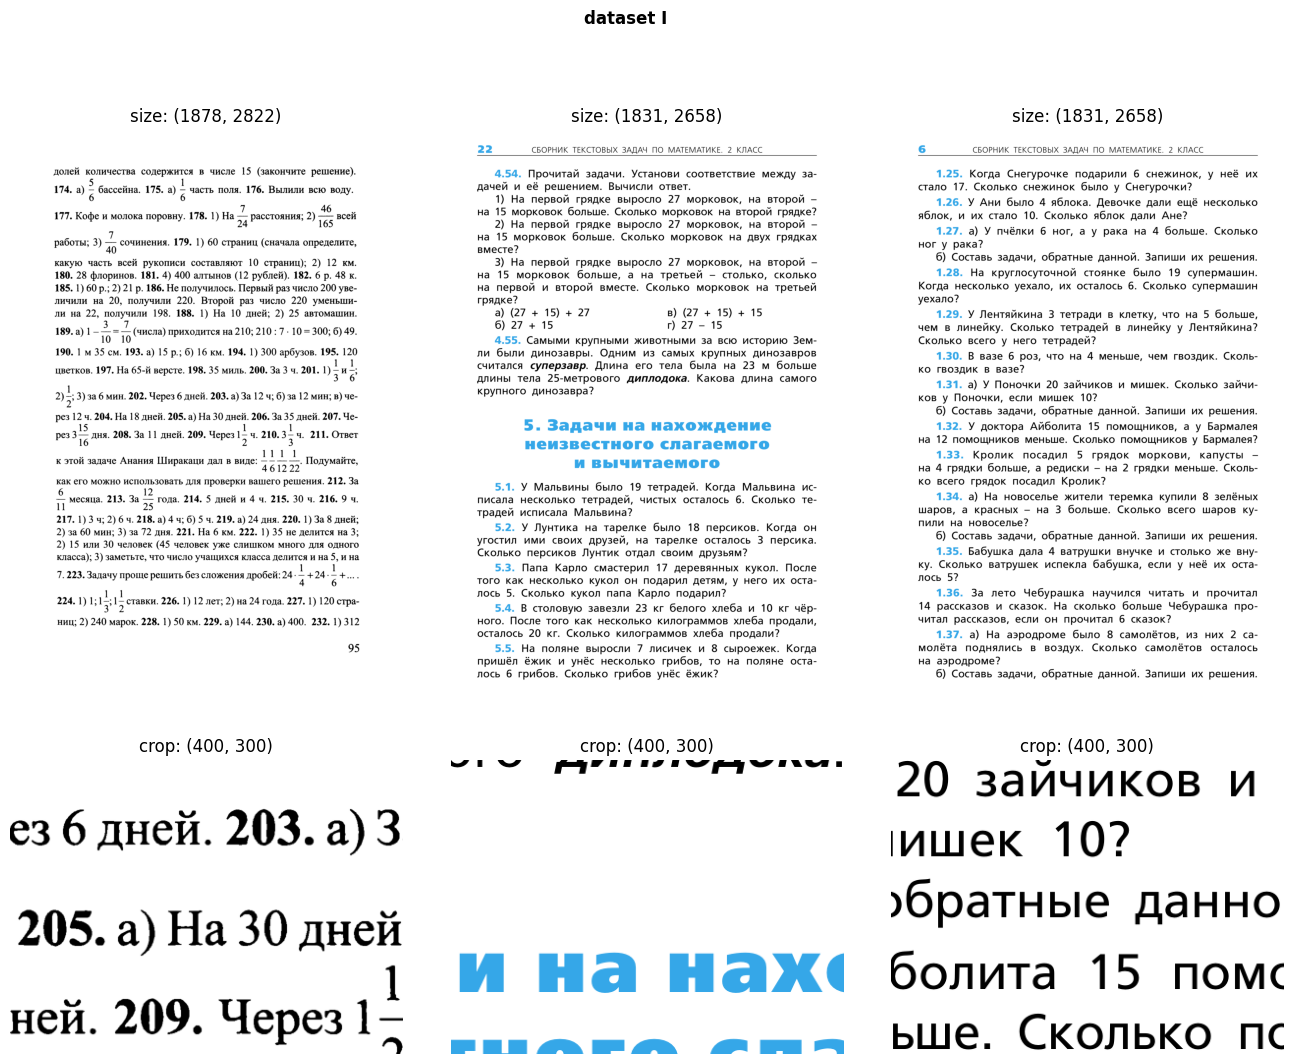

In [270]:
show_dataset(CFG.dataset_test.joinpath('doc1'), 'dataset I')

### dataset II

В качестве второго датасета возьмем более "сложные" для моделей изображения. Будет уменьшено разрешение, ухудшено качество, добавлены различные шумы и искажения, изменена цветовая палитра.
Второй датасет искусственно получим из первого, применив к каждому изображению случайный набор искажений.

In [852]:
def distortion_preprocess(img, transforms_alb, transforms_torch):
    img = np.array(img)
    img = transforms_alb(image=img)['image']
    # img = Image.fromarray(img)
    img = v2.functional.to_image(img)
    img = transforms_torch(img)
    img = v2.functional.to_pil_image(img)
    return img


transforms_alb = A.Compose([
    A.LongestMaxSize(max_size=900),
    A.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2, p=.25),
    ColorShiftAlb(min_val=.8, p=.8),
    A.Affine(rotate=(-1, 1), fit_output=True, border_mode=cv2.BORDER_CONSTANT, p=.6),
    A.Perspective(scale=(.001, .02), fit_output=True, p=.4),
    A.GaussNoise(std_range=(.01, .09), p=.4),
    A.ElasticTransform(alpha=3, sigma=50, p=.2),
    ])

transforms_torch=v2.Compose([
    T.RandomApply(T.RandomShadow((0, .2)), p=.4),
])

In [853]:
edit_dataset(CFG.dataset_test / 'doc1', CFG.dataset_test / 'doc2', distortion_preprocess, transforms_alb, transforms_torch)

  0%|          | 0/87 [00:00<?, ?it/s]

Посмотрим несколько случайных примеров:

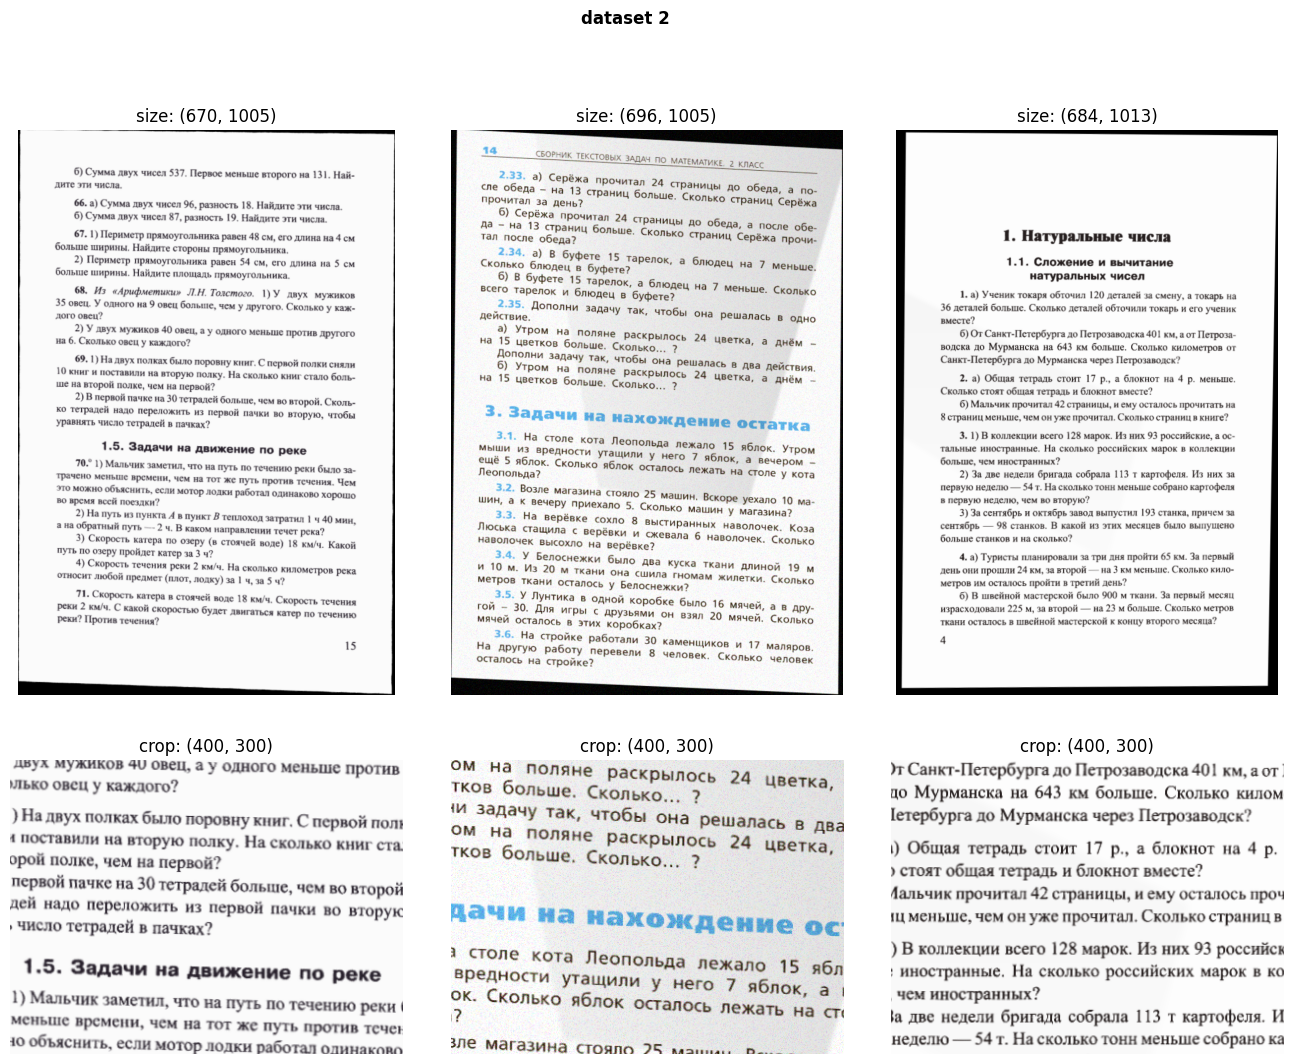

In [814]:
show_dataset(CFG.dataset_test.joinpath('doc2'), 'dataset 2')

### dataset III

Предположим, что у нас нет первого датасета, а есть только второй, с изображениями в плохом качестве. Не будет лишним перед подачей в модель постараться очистить изображения, максимально убрав шум, артефакты и т.д.  
Попробуем подобрать в библиотеке `openCV` инструменты для устранения дефектов.

In [199]:
def improve_preprocess(img):
    # img = img.resize((int(img.width * 2), int(img.height * 2)), Image.Resampling.LANCZOS)
    img = np.array(img)
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Разделяем каналы
    channels = cv2.split(img)
    processed_channels = []

    for ch in channels:

        # Улучшение контраста
        clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(4, 4))
        ch = clahe.apply(ch)

        # Удаление шума (Denoising)
        denoised = cv2.medianBlur(ch, 1)
        # denoised = cv2.GaussianBlur(ch, (1, 1), 1)
        ch = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # # Sauvola thresholding
        # thresh_sauvola = threshold_sauvola(ch, window_size=25, k=.01)
        # binary_sauvola = ch > thresh_sauvola
        # ch = (binary_sauvola * 255).astype('uint8')
        
        # Sharpening
        kernel = np.array([  # Фильтр повышения резкости
            [0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0]
        ])
        ch = cv2.filter2D(ch, -1, kernel)

        # Morphological cleaning
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        ch = cv2.morphologyEx(ch, cv2.MORPH_OPEN, kernel, iterations=1)
        
        processed_channels.append(ch)

    # Объединяем каналы
    img = cv2.merge(processed_channels)
    img = Image.fromarray(img)
    return img

In [865]:
edit_dataset(CFG.dataset_test / 'doc2', CFG.dataset_test / 'doc3', improve_preprocess)

  0%|          | 0/87 [00:00<?, ?it/s]

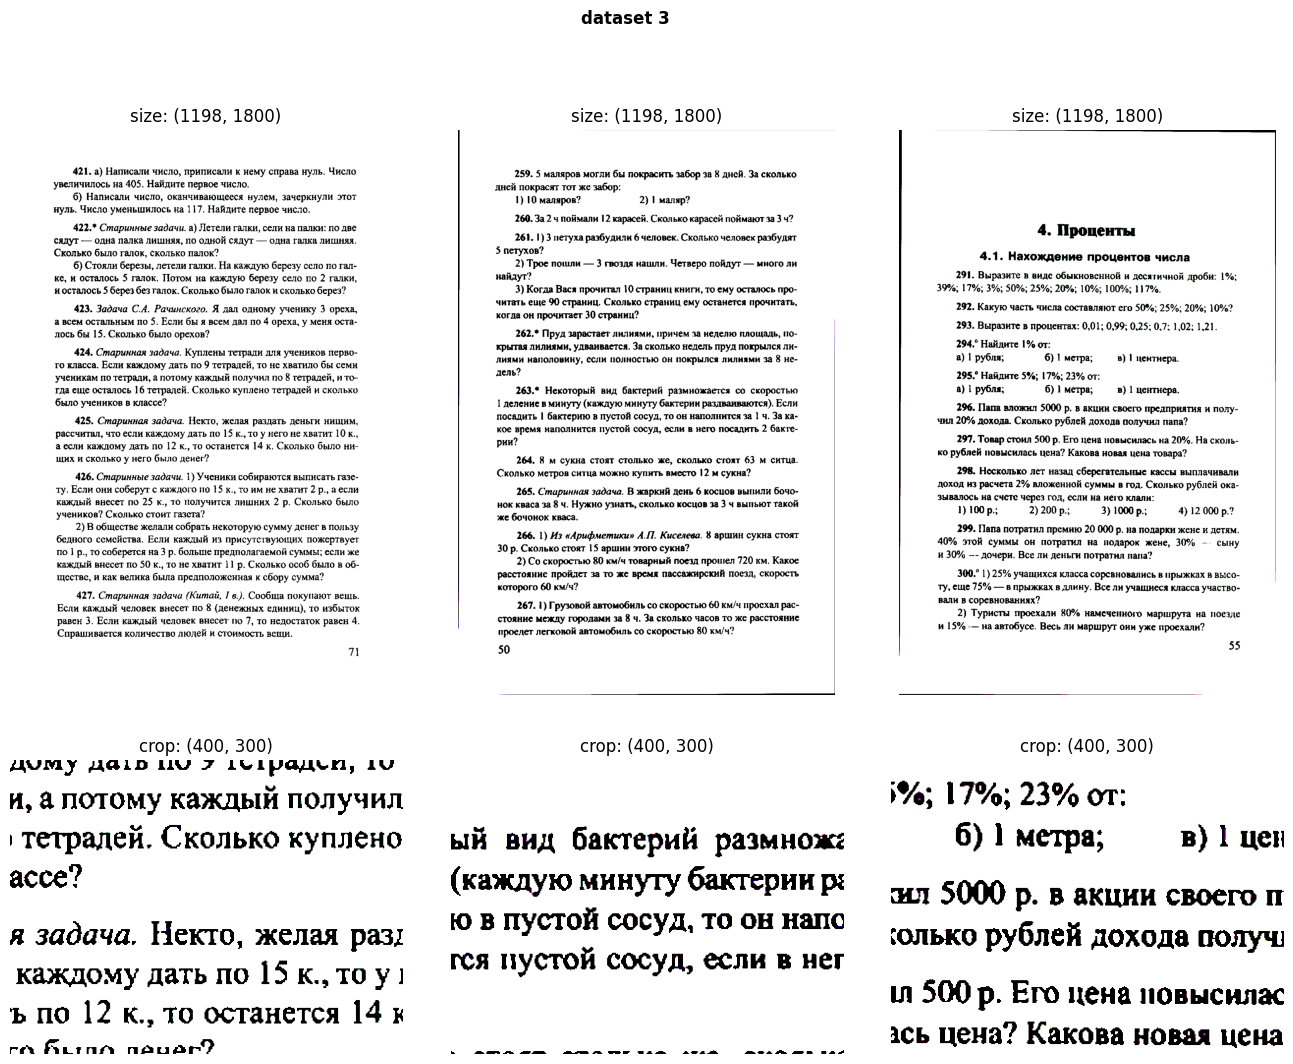

In [866]:
show_dataset(CFG.dataset_test.joinpath('doc3'), 'dataset 3')

## DocTR

### Data preparation and model training

За основу возьмем модели из библиотеки **[docTR](https://github.com/mindee/doctr)**, которые дообучим под нашу задачу.

Для обучения моделей необходимы тренировочные датасеты. Подход к их созданию описан в ноутбуке **[synthetic_datasets.ipynb](synthetic_datasets.ipynb)**.

В ноутбуках **[train_recognition.ipynb](train_recognition.ipynb)** и **[train_detection.ipynb](train_detection.ipynb)** описан процесс обучения модели распознавания и модели детекции.

### Load weights

In [181]:
state_recognition = torch.load(
    # CFG.models_best / 'best_vitstr_small.pth', 
    CFG.models_save / 'vitstr_exp3_epoch10.pth', 
    map_location=DEVICE, 
    weights_only=True
)

state_detection = torch.load(
    CFG.models_best / 'best_linknet_resnet18.pth', 
    # CFG.models_save / 'linknet_resnet18_exp1_epoch19.pth', 
    map_location=DEVICE, 
    weights_only=True
)

Загружаем веса в модели распознавания и детекции

In [182]:
model_recognition = recognition.vitstr_small(vocab=CFG.vocab).to(DEVICE)
model_recognition.load_state_dict(state_recognition['model'])

model_detection = detection.linknet_resnet18(pretrained=True).to(DEVICE)
model_detection.load_state_dict(state_detection['model'])

/home/lake/anaconda3/envs/lime_test/lib/python3.11/site-packages/doctr/models/utils/pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(arch

<All keys matched successfully>

Получаем цельную модель для OCR

In [183]:
model = ocr_predictor(det_arch=model_detection, reco_arch=model_recognition).to(DEVICE)

### Средняя точность

#### dataset I

In [145]:
calculation_score(model, get_predict_doctr, CFG.dataset_test / 'doc1', translate_gt=True)

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1633, words: 289)

CER:     0.0134
WER:     0.0479


#### dataset II

In [858]:
calculation_score(model, get_predict_doctr, CFG.dataset_test / 'doc2', translate_gt=True)

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1637, words: 289)

CER:     0.0193
WER:     0.0704


#### dataset III

In [867]:
calculation_score(model, get_predict_doctr, CFG.dataset_test / 'doc3', translate_gt=True)

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1635, words: 291)

CER:     0.0325
WER:     0.1159


На чистом датасете получаем **4.8%** ошибок на уровне слов. На боле сложном датасете процент ошибок поднимается до **7%**. При попытке улучшить некачественные данные модель показала еще более более худший результат. Скорее всего это связано с тем, что модель мы в том числе обучали на искаженных изображениях, и она научилась вытягивать из некачественных данных больше информации, чем пропускают фильтры из cv2, которые мы применили для повышения качества. Либо же набор преобразований был подобран не самый оптимальный.

### Примеры работы модели

Несколько примеров работы модели. Красным цветом отмечены ошибки. 

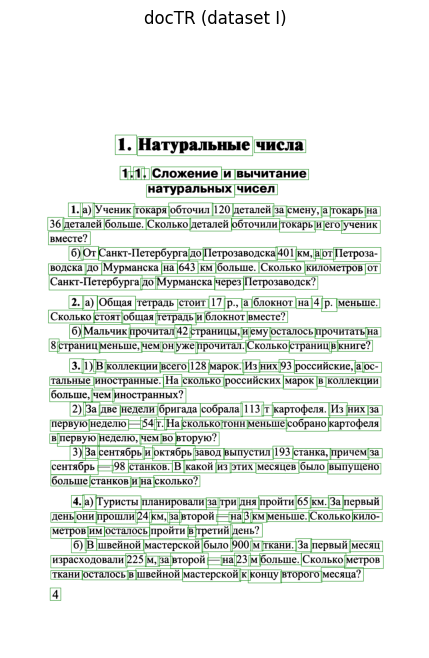

CER: 0.0085
WER: 0.0410

--------------------------------------------------------------------------------
Ground Truth (chars:1408, words:244)
1. Натуральные числа
1.1. Сложение и вычитание
натуральных чисел
1. а) Ученик токаря обточил 120 деталей за смену, а токарь на
36 деталей больше. Сколько деталей обточили токарь и его ученик
вместе?
б) От Санкт-Петербурга до Петрозаводска 401 км, а от Петроза-
водска до Мурманска на 643 км больше. Сколько километров от
Санкт-Петербурга до Мурманска через Петрозаводск?
2. а) Общая тетрадь стоит 17 р., а блокнот на 4 р. меньше.
Сколько стоят общая тетрадь и блокнот вместе?
б) Мальчик прочитал 42 страницы, и ему осталось прочитать на
8 страниц меньше, чем он уже прочитал. Сколько страниц в книге?
3. 1) В коллекции всего 128 марок. Из них 93 российские, а ос-
тальные иностранные. На сколько российских марок в коллекции
больше, чем иностранных?
2) За две недели бригада собрала 113 т картофеля. Из них за
первую неделю - 54 т. На сколько тонн меньше со

In [15]:
show_predict(
    model, 
    get_predict_doctr, 
    CFG.dataset_test / 'doc1', 
    'book_page0004.png',
    title='docTR (dataset I)',
    translate_gt=True,
)

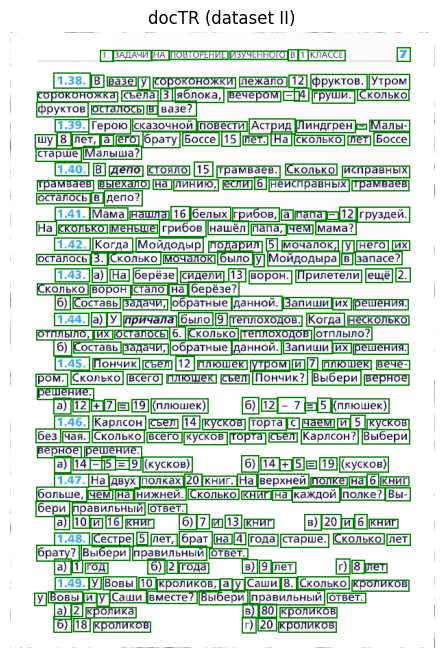

CER: 0.0098
WER: 0.0462

--------------------------------------------------------------------------------
Ground Truth (chars:1738, words:325)
1. ЗАДАЧИ НА ПОВТОРЕНИЕ ИЗУЧЕННОГО В 1 КЛАССЕ
7
1.38. В вазе у сороконожки лежало 12 фруктов. Утром
сороконожка съела 3 яблока, вечером - 4 груши. Сколько
фруктов осталось в вазе?
1.39. Герою сказочной повести Астрид Линдгрен - Малы-
шу 8 лет, а его брату Боссе 15 лет. На сколько лет Боссе
старше Малыша?
1.40. В депо стояло 15 трамваев. Сколько исправных
трамваев выехало на линию, если 6 неисправных трамваев
осталось в депо?
1.41. Мама нашла 16 белых грибов, а папа - 12 груздей.
На сколько меньше грибов нашёл папа, чем мама?
1.42. Когда Мойдодыр подарил 5 мочалок, у него их
осталось 3. Сколько мочалок было у Мойдодыра в запасе?
1.43. а) На берёзе сидели 13 ворон. Прилетели ещё 2.
Сколько ворон стало на берёзе?
б) Составь задачи, обратные данной. Запиши их решения.
1.44. а) У причала было 9 теплоходов. Когда несколько
отплыло, их осталось 6. Скол

In [48]:
show_predict(
    model, 
    get_predict_doctr, 
    CFG.dataset_test / 'doc2', 
    'zadachi_page0005.png',
    title='docTR (dataset II)',
    translate_gt=True,
)

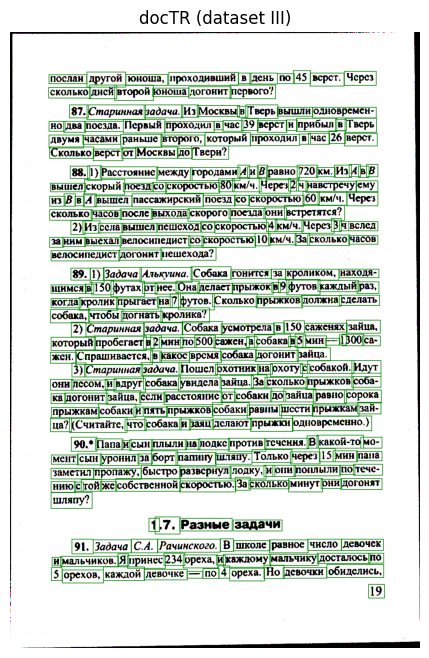

CER: 0.0252
WER: 0.1280

--------------------------------------------------------------------------------
Ground Truth (chars:1908, words:328)
послан другой юноша, проходивший в день по 45 верст. Через
сколько дней второй юноша догонит первого?
87. Старинная задача. Из Москвы в Тверь вышли одновремен-
но два поезда. Первый проходил в час 39 верст и прибыл в Тверь
двумя часами раньше второго, который проходил в час 26 верст.
Сколько верст от Москвы до Твери?
88. 1) Расстояние между городами АиВ равно 720 км. Из А в В
вышел скорый поезд со скоростью 80 км/ч. Через 2 ч навстречу ему
из В в А вышел пассажирский поезд со скоростью 60 км/ч. Через
сколько часов после выхода скорого поезда они встретятся?
2) Из села вышел пешеход со скоростью 4 км/ч. Через 3 ч вслед
за ним выехал велосипедист со скоростью 10 км/ч. За сколько часов
велосипедист догонит пешехода?
89. 1) Задача Алъкуина. Собака гонится за кроликом, находя-
щимся в 150 футах от нее. Она делает прыжок в 9 футов каждый раз,
когда кр

In [49]:
show_predict(
    model, 
    get_predict_doctr, 
    CFG.dataset_test / 'doc3', 
    'book_page0019.png', 
    title='docTR (dataset III)',
    translate_gt=True,
)

# Testing ready-made solutions

Сравним полученные результаты с другими OCR моделями, которые изначально обучены для работы с русскоязычным текстом.

## EasyOCR

In [17]:
# !pip install easyocr

In [18]:
import easyocr

In [19]:
def get_predict_easyocr(model, img_array, return_boxes=False):
    output = model.readtext(img_array)
    text_total, text_string, boxes = [], [], []
    current_bottom = None
    
    for bbox, txt, _ in output:
        if current_bottom is None:
            current_bottom = bbox[2][1]

        if bbox[2][1] > current_bottom + 15:
            text_total.append(' '.join(text_string))
            text_string = []
            current_bottom = bbox[2][1]

        boxes.append([tuple(cord) for cord in bbox])
        text_string.append(txt)

    text_total.append(' '.join(text_string))
    text_total = '\n'.join(text_total)
    
    if not return_boxes:
        return text_total
    
    return text_total, boxes, 'polygon'

In [20]:
model_easyocr = easyocr.Reader(['ru'], gpu=IS_CUDA)

### Средняя точность

#### dataset I

In [21]:
calculation_score(model_easyocr, get_predict_easyocr, CFG.dataset_test / 'doc1')

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1617, words: 285)

CER:     0.0485
WER:     0.1459


#### dataset II

In [23]:
calculation_score(model_easyocr, get_predict_easyocr, CFG.dataset_test / 'doc2')

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1553, words: 262)

CER:     0.1131
WER:     0.3500


#### dataset III

In [22]:
calculation_score(model_easyocr, get_predict_easyocr, CFG.dataset_test / 'doc3')

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1614, words: 284)

CER:     0.1027
WER:     0.3323


### Пример работы модели

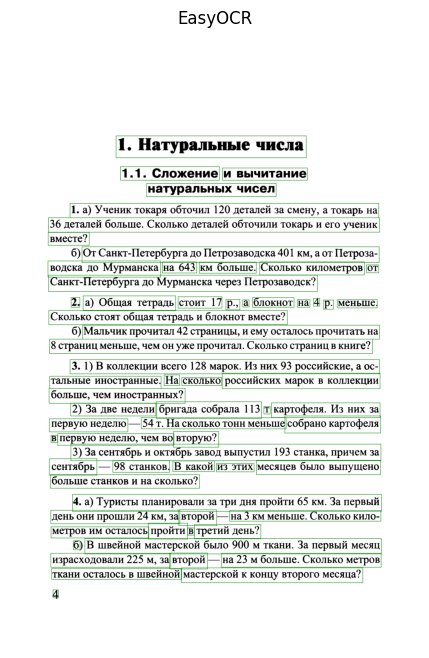

CER: 0.0391
WER: 0.1393

--------------------------------------------------------------------------------
Ground Truth (chars:1408, words:244)
1. Натуральные числа
1.1. Сложение и вычитание
натуральных чисел
1. а) Ученик токаря обточил 120 деталей за смену, а токарь на
36 деталей больше. Сколько деталей обточили токарь и его ученик
вместе?
б) От Санкт-Петербурга до Петрозаводска 401 км, а от Петроза-
водска до Мурманска на 643 км больше. Сколько километров от
Санкт-Петербурга до Мурманска через Петрозаводск?
2. а) Общая тетрадь стоит 17 р., а блокнот на 4 р. меньше.
Сколько стоят общая тетрадь и блокнот вместе?
б) Мальчик прочитал 42 страницы, и ему осталось прочитать на
8 страниц меньше, чем он уже прочитал. Сколько страниц в книге?
3. 1) В коллекции всего 128 марок. Из них 93 российские, а ос-
тальные иностранные. На сколько российских марок в коллекции
больше, чем иностранных?
2) За две недели бригада собрала 113 т картофеля. Из них за
первую неделю — 54 т. На сколько тонн меньше со

In [51]:
show_predict(
    model_easyocr, 
    get_predict_easyocr, 
    CFG.dataset_test / 'doc1', 
    'book_page0004.png',
    title='EasyOCR'
)

## Tesseract

In [19]:
# !pip install pytesseract

In [203]:
import pytesseract
from pytesseract import Output

In [204]:
def get_predict_tesseract(model, img_array, return_boxes=False):
    pred_text = model.image_to_string(img_array, lang='rus')
    
    if not return_boxes:
        return pred_text

    data = model.image_to_data(img, lang='rus', output_type=Output.DICT)
    
    boxes = []
    n_boxes = len(data['level'])
    for i in range(n_boxes):
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        boxes.append([x, y, x + w, y + h])
        
    return pred_text, boxes, 'rectangle'

### Средняя точность

#### dataset I

In [26]:
calculation_score(pytesseract, get_predict_tesseract, CFG.dataset_test / 'doc1')

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1637, words: 287)

CER:     0.0137
WER:     0.0334


#### dataset II

In [27]:
calculation_score(pytesseract, get_predict_tesseract, CFG.dataset_test / 'doc2')

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1633, words: 284)

CER:     0.0209
WER:     0.0694


#### dataset III

In [28]:
calculation_score(pytesseract, get_predict_tesseract, CFG.dataset_test / 'doc3')

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1624, words: 285)

CER:     0.0281
WER:     0.0670


### Пример работы модели

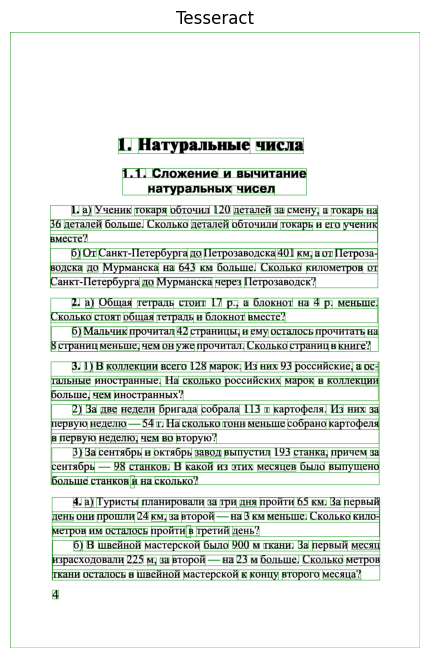

CER: 0.0107
WER: 0.0164

--------------------------------------------------------------------------------
Ground Truth (chars:1408, words:244)
1. Натуральные числа
1.1. Сложение и вычитание
натуральных чисел
1. а) Ученик токаря обточил 120 деталей за смену, а токарь на
36 деталей больше. Сколько деталей обточили токарь и его ученик
вместе?
б) От Санкт-Петербурга до Петрозаводска 401 км, а от Петроза-
водска до Мурманска на 643 км больше. Сколько километров от
Санкт-Петербурга до Мурманска через Петрозаводск?
2. а) Общая тетрадь стоит 17 р., а блокнот на 4 р. меньше.
Сколько стоят общая тетрадь и блокнот вместе?
б) Мальчик прочитал 42 страницы, и ему осталось прочитать на
8 страниц меньше, чем он уже прочитал. Сколько страниц в книге?
3. 1) В коллекции всего 128 марок. Из них 93 российские, а ос-
тальные иностранные. На сколько российских марок в коллекции
больше, чем иностранных?
2) За две недели бригада собрала 113 т картофеля. Из них за
первую неделю — 54 т. На сколько тонн меньше со

In [77]:
show_predict(
    pytesseract, 
    get_predict_tesseract, 
    CFG.dataset_test / 'doc1', 
    'book_page0004.png', 
    title='Tesseract'
)

## PaddleOCR

In [181]:
# !pip install paddlepaddle==2.6.1 paddleocr

In [29]:
from paddleocr import PaddleOCR

In [30]:
def get_predict_paddle(model, img_array, return_boxes=False):
    output = model.ocr(img_array)
    text_total, text_string, boxes = [], [], []
    current_bottom = None

    for bbox, txt in output[0]:
        if current_bottom is None:
            current_bottom = bbox[2][1]

        if bbox[2][1] > current_bottom + 15:
            text_total.append(' '.join(text_string))
            text_string = []
            current_bottom = bbox[2][1]
            
        boxes.append([tuple(map(int, cord)) for cord in bbox])
        text_string.append(txt[0])

    text_total.append(' '.join(text_string))
    text_total = '\n'.join(text_total)

    if not return_boxes:
        return text_total
    
    return text_total, boxes, 'polygon'

In [43]:
model_paddle = PaddleOCR(lang='ru', use_angle_cls=True, show_log=False)

### Средняя точность

#### dataset I

In [32]:
calculation_score(model_paddle, get_predict_paddle, CFG.dataset_test / 'doc1')

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1528, words: 264)

CER:     0.3871
WER:     0.6770


#### dataset II

In [33]:
calculation_score(model_paddle, get_predict_paddle, CFG.dataset_test / 'doc2')

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1340, words: 232)

CER:     0.4080
WER:     0.8336


#### dataset III

In [34]:
calculation_score(model_paddle, get_predict_paddle, CFG.dataset_test / 'doc3')

  0%|          | 0/87 [00:00<?, ?it/s]

Lengths GT:   (chars: 1626, words: 287)
Lengths pred: (chars: 1443, words: 250)

CER:     0.4156
WER:     0.7865


### Пример работы модели

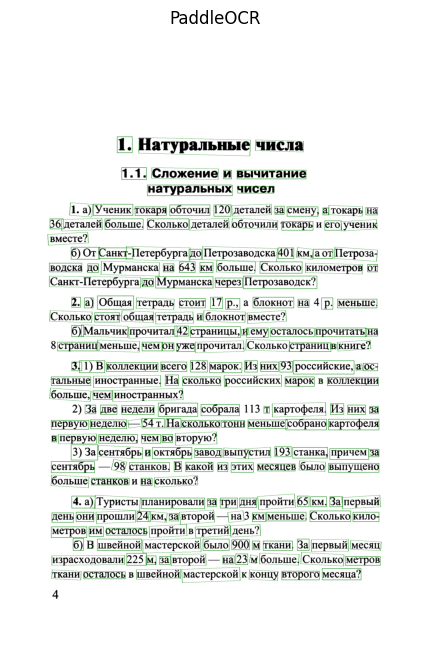

CER: 0.3324
WER: 0.6311

--------------------------------------------------------------------------------
Ground Truth (chars:1408, words:244)
1. Натуральные числа
1.1. Сложение и вычитание
натуральных чисел
1. а) Ученик токаря обточил 120 деталей за смену, а токарь на
36 деталей больше. Сколько деталей обточили токарь и его ученик
вместе?
б) От Санкт-Петербурга до Петрозаводска 401 км, а от Петроза-
водска до Мурманска на 643 км больше. Сколько километров от
Санкт-Петербурга до Мурманска через Петрозаводск?
2. а) Общая тетрадь стоит 17 р., а блокнот на 4 р. меньше.
Сколько стоят общая тетрадь и блокнот вместе?
б) Мальчик прочитал 42 страницы, и ему осталось прочитать на
8 страниц меньше, чем он уже прочитал. Сколько страниц в книге?
3. 1) В коллекции всего 128 марок. Из них 93 российские, а ос-
тальные иностранные. На сколько российских марок в коллекции
больше, чем иностранных?
2) За две недели бригада собрала 113 т картофеля. Из них за
первую неделю — 54 т. На сколько тонн меньше со

In [53]:
show_predict(
    model_paddle, 
    get_predict_paddle, 
    CFG.dataset_test / 'doc1', 
    'book_page0004.png', 
    title='PaddleOCR'
)

## Donut

Данную модель у меня не получилось запустить на моем GPU, поэтому я не буду ее тестировать на всем наборе данных, достаточно пары примеров, что бы понять, что для нашей задачи эта модель не подойдет.

In [13]:
# pip install transformers

In [31]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
from transformers import logging

In [32]:
# Отключение всех сообщений, кроме ошибок
logging.set_verbosity_error()

In [85]:
def get_predict_donut(model, img_array, return_boxes=False):
    # Предобработка изображения
    pixel_values = processor(img_array, return_tensors="pt").pixel_values
    # Генерация текста
    generated_ids = model.generate(pixel_values)
    # Декодирование сгенерированного текста
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    if not return_boxes:
        return text
    
    return text, None, None

In [81]:
processor = DonutProcessor.from_pretrained("Akajackson/donut_rus")
model_donut = VisionEncoderDecoderModel.from_pretrained("Akajackson/donut_rus")

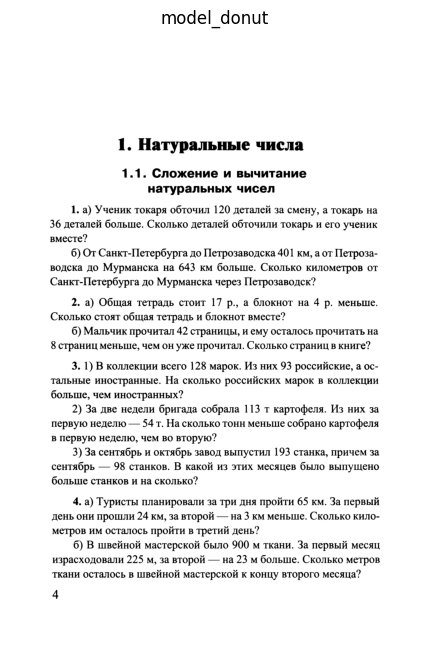

CER: 0.1392
WER: 0.2910

--------------------------------------------------------------------------------
Ground Truth (chars:1408, words:244)
1. Натуральные числа
1.1. Сложение и вычитание
натуральных чисел
1. а) Ученик токаря обточил 120 деталей за смену, а токарь на
36 деталей больше. Сколько деталей обточили токарь и его ученик
вместе?
б) От Санкт-Петербурга до Петрозаводска 401 км, а от Петроза-
водска до Мурманска на 643 км больше. Сколько километров от
Санкт-Петербурга до Мурманска через Петрозаводск?
2. а) Общая тетрадь стоит 17 р., а блокнот на 4 р. меньше.
Сколько стоят общая тетрадь и блокнот вместе?
б) Мальчик прочитал 42 страницы, и ему осталось прочитать на
8 страниц меньше, чем он уже прочитал. Сколько страниц в книге?
3. 1) В коллекции всего 128 марок. Из них 93 российские, а ос-
тальные иностранные. На сколько российских марок в коллекции
больше, чем иностранных?
2) За две недели бригада собрала 113 т картофеля. Из них за
первую неделю — 54 т. На сколько тонн меньше со

In [86]:
show_predict(
    model_donut, 
    get_predict_donut, 
    CFG.dataset_test / 'doc1', 
    'book_page0004.png', 
    title='model_donut'
)

## Summary

Резюмируем результаты тестов и составим сводную таблицу со средними значениями метрики **[WER](https://torchmetrics.readthedocs.io/en/v0.8.2/text/word_error_rate.html)** (процент ошибок, совершенных моделью на уровне отдельных слов) для трех датасетов:
- `set I` - изображения хорошего качества
- `set II` - изображения ухудшенного качества
- `set III` - очищенные с помощью инструментов из cv2 данные из **set II**


| model | set I | set II | set III |
| --- | --- | --- | --- |
| docTR (train) | 4.79% | 7.04% | 11.59% |
| Tesseract | 3.34% | 6.94% | 6.70% |
| EasyOCR | 14.59% | 35.00% | 33.23% |
| PaddleOCR | 67.70% | 83.36% | 78.65% |

Как видно из таблицы, приемлемое качество получилось только на docTR и Tesseract, так что подробнее остановимся только на этих двух моделях.

На "чистых" данных модель **docTR**, которую мы обучали, уступила в качестве **Tesseract** `1.45%`. На зашумленных данных разницы практически нет, она составляет `0.1%`. Попытка очистить зашумленные данные позволила немного улучшить качество на модели **Tesseract** на `0.24%`, тогда как на **docTR** это только ухудшило результат.

Обученная нами модель **docTR** получилась боле устойчивой к качеству входных данных, так как падение падение метрики составило `2.25%` при ухудшении датасета. Тогда как **Tesseract** просел в качестве на `3.6%`, но в целом оказался несколько более точным.

Попытка улучшить качество загрязненных данных с помощью инструментов из cv2 оказалась неудачной в случае **docTR**, скорее всего эта связано с тем, что при очистке изображений потерялась часть важной для данной модели информации. Тут можно попробовать другие варианты восстановления качества изображения, например, с применением нейронных сетей, либо же обучать модель на более "злых" аугментациях, что бы сделать ее еще более устойчивой. Плюс можно взять более сложную recognition model. На **Tesseract** данная операция улучшения качества изображений дала небольшой выигрыш в значении метрики.

---

С таблицами все несколько сложнее. Я пока не придумал, как можно с помощью метрик измерить качество в распознавании таблиц. Если со сплошным текстом все просто - достаточно сравнить предсказанный и оригинальный тексты. В то время как каждую табличную ячейку нужно обрабатывать отдельно, проверяя пространственное положение каждого кусочка текста.

Сейчас получается следующее:

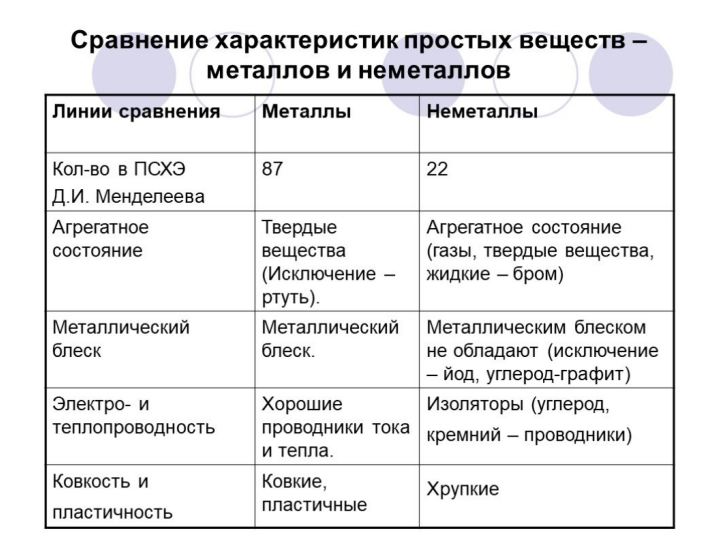

In [185]:
img = Image.open('dataset_test/table2.jpg').convert('RGB')
img = np.array(img)
plt.figure(figsize=(9, 9))
plt.imshow(img)
plt.axis(False)
plt.show()

Подав ее в модель, можно получить просто текст, который мало отражает структуру таблицы

In [186]:
result = model([img])
print(result.render())

Сравнение характеристик простых веществ -
металлов и неметаллов
Линии сравнения - Металлы
Неметаллы -
- -
Кол-во в ПСХЭ
87
22
д.и. Менделеева
Агрегатное
Твердые
Агрегатное состояние
состояние
вещества
(газы, твердые вещества,
(Исключение -
жидкие - бром)
ртуть).
Металлический
| Металлический
Металлическим блеском
блеск
блеск.
не обладают (исключение
- Йод, угперод-графит)
Электро- и
Хорошие
Изоляторы (углерод,
теппопроводность
проводники тока | кремний - проводники)
и тепла.
Ковкость и
Ковкие,
Хрупкие
пластичность
- пластичные


Но если отрисовать предсказанный текст на двумерной плоскости, используя координаты предсказанных bounding boxes, то результат получается более удовлетворительный

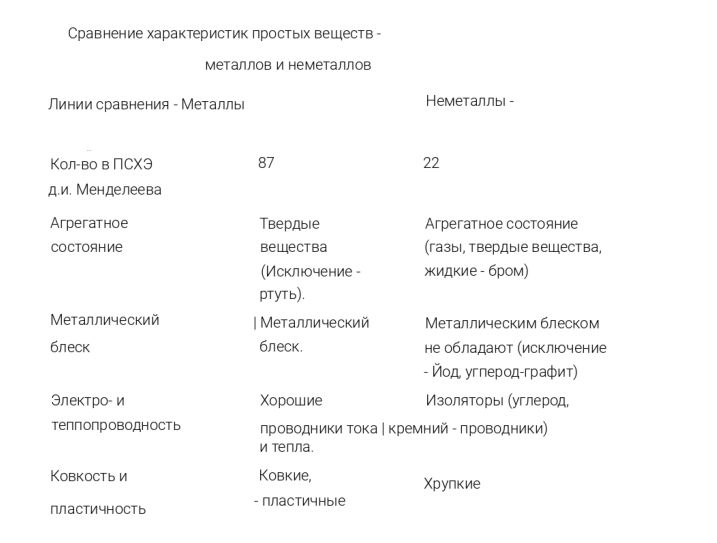

In [191]:
img = result.synthesize(font_family='fonts/Roboto/Roboto-Light.ttf', min_font_size=22, max_font_size=22)[0]
plt.figure(figsize=(9, 9))
plt.imshow(img)
plt.axis(False)
plt.show()

Видно, что некоторые части табличной рамки определились, как символы. Что бы от этого избавиться, нужно дополнительно обучать модель детекции.  
Например, в правом нижнем углу надпись "кремний" наполовину заползла в соседнюю ячейку, так как рамка таблицы в этом месте была принята моделью за символ вертикальной черты. И не понятно, как метрически измерить качество такого предсказания - слово предсказано верно, но смещено в пространстве. Возможно, с табличными данными небходимо работать отдельно, как к примеру с формулами или картинками в тесте - вырезать область из исходного изображения и обрабатывать своей моделью.

В tesseract есть специальный режим для работы с таблицами, но он тоже дает не идеальный результат:

In [196]:
text = pytesseract.image_to_string(img, config=r'--oem 1 --psm 6', lang='rus')
print(text)

Сравнение характеристик простых веществ -
металлов и неметаллов
Линии сравнения - Металлы Неметаллы -
Кол-во в ПСХЭ 87 22
д.и. Менделеева
Агрегатное Твердые Агрегатное состояние
состояние вещества (газы, твердые вещества,
(Исключение - жидкие - бром)
ртуть)
Металлический | Металлический Металлическим блеском
блеск блеск. не обладают (исключение
- Йод, угперод-графит)
Электро- и Хорошие Изоляторы (углерод,
теппопроводность проводники тока | кремний - проводники)
и тепла
Ковкость и Ковкие, Хрупкие
пластичность пластичные

